In [24]:
import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
import seaborn as sns 
from joblib import dump
from joblib import load
import time
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_recall_fscore_support, plot_confusion_matrix, plot_precision_recall_curve
from sklearn.feature_selection import SelectFromModel

In [25]:
X_train = pd.read_csv('X_train_pca.csv')
y_train = pd.read_csv('y_train.csv')
holdout = pd.read_csv('df_h_pca.csv')

In [26]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,-1.593356,1.669345,0.485182,-0.488738,-0.013172,0.341424,-0.067744,-0.629556,0.631818,-0.224100,...,-0.063315,-0.029822,-0.061270,0.045718,-0.012868,-0.007344,-0.032531,-0.025180,-0.008729,-0.015971
1,-1.529292,1.672648,0.441669,-0.506389,-0.061353,0.369166,-0.064896,-0.626892,0.615794,-0.173749,...,-0.068806,-0.030480,-0.062651,0.053774,-0.007081,-0.008953,-0.026717,-0.021488,-0.006320,-0.010030
2,-1.445299,1.666598,0.420815,-0.535050,-0.119022,0.379757,-0.066653,-0.605994,0.591155,-0.147865,...,-0.064247,-0.027593,-0.056497,0.059192,-0.000061,-0.008979,-0.022687,-0.020684,-0.000046,-0.002719
3,-1.319651,1.640965,0.446621,-0.586713,-0.197696,0.354527,-0.077906,-0.547356,0.548597,-0.171514,...,-0.039318,-0.016865,-0.035073,0.059619,0.009603,-0.005898,-0.022549,-0.025616,0.014112,0.007295
4,-1.234909,1.639589,0.436070,-0.604991,-0.261456,0.341620,-0.080155,-0.534751,0.541604,-0.176264,...,-0.034881,-0.006702,-0.029694,0.048313,0.016192,-0.008487,-0.020978,-0.024503,0.017094,0.007382


In [27]:
y_train.value_counts()

Class
-1.0     8528
 1.0     1435
dtype: int64

In [28]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
#checking initially number of records in each class
unique, count= np.unique(y_train,return_counts=True)
ytrain_dict_value_count={k:v for (k,v) in zip(unique, count)}
ytrain_dict_value_count

{-1.0: 8528, 1.0: 1435}

In [29]:
# define oversampling strategy
over = RandomOverSampler(sampling_strategy={-1:8528, 1:8000 })
# fit and apply the transform
Xtrain_oslr, ytrain_oslr = over.fit_resample(X_train, y_train)
#  check new class distribution
print(Counter(ytrain_oslr))

Counter({'Class': 1})


## Random forest - Cost sensitive balancing

In [42]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(class_weight="balanced")

param_grid = {
        'n_estimators': [300],
        'max_depth': [5]
}


# we'll use 5-fold cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=5, 
                              scoring='f1_macro',return_train_score=True, n_jobs=-1)

start = time.time()
grid_search.fit(X_train, y_train)
end = time.time() - start
print(f"Took {end} seconds")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Took 16.39242959022522 seconds


In [43]:
#Best estimators from the grid search 
rfc_best_estimate = grid_search.best_estimator_

In [44]:
#check the average accuracy over the five k-fold 
grid_search.best_score_

0.6933896841333319

In [45]:
best_model_index = grid_search.cv_results_["rank_test_score"].tolist().index(1)
best_model_index

0

In [46]:
log_split_test_scores = []
for x in range(5):
    # extract f-score of the best model (index='best_model_index') from each of the 5 splits
    val = grid_search.cv_results_[f"split{x}_test_score"][best_model_index]
    log_split_test_scores.append(val)

In [47]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
0,"{'max_depth': 5, 'n_estimators': 300}",0.945965,0.69339,26.700293


In [48]:
import os
from joblib import dump

if not os.path.exists('models'):
    os.makedirs('models')
    
dump(rfc_best_estimate, 'models/rfc_best_estimate.joblib')

['models/rfc_best_estimate.joblib']

In [49]:
X_test = pd.read_csv('X_test_pca.csv')
y_test = pd.read_csv('y_test.csv')

In [50]:
from sklearn.metrics import precision_recall_fscore_support
best_rf = load('models/rfc_best_estimate.joblib')
yhat_rf = best_rf.predict(X_test)

p, r, rf_test_score, s = precision_recall_fscore_support(y_test, yhat_rf, average = 'macro')

print(f' F score: {rf_test_score}')

 F score: 0.5741279191855476


In [51]:
from sklearn.metrics import confusion_matrix
cfsn_matrix = confusion_matrix(y_test, yhat_rf)
print(cfsn_matrix)

[[6895   34]
 [1275  201]]


In [52]:
#Converting the values into proportions based on category
cfsn_matrix = (cfsn_matrix.T/cfsn_matrix.sum(axis=1)).T

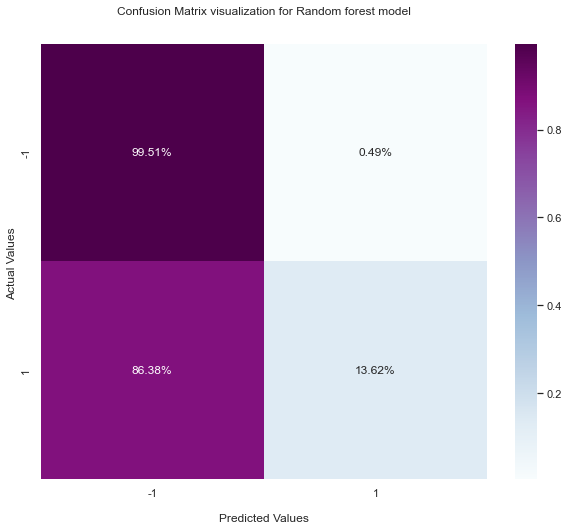

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

#Setting figure size
sns.set(rc={'figure.figsize':(10,8)})
#Creating heatmap to visually interpret the values better
ax = sns.heatmap(cfsn_matrix, annot=True, 
            fmt='.2%', cmap='BuPu')

ax.set_title('Confusion Matrix visualization for Random forest model\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

#Setting ticket labels
ax.xaxis.set_ticklabels([-1, 1])
ax.yaxis.set_ticklabels([-1, 1])

# Displaying the heatmap
plt.show()

In [54]:
# put them into a separate variable for convenience
feature_importances = grid_search.best_estimator_.feature_importances_

# the order of the features in `feature_importances` is the same as in the Xtrain dataframe,
# so we can "zip" the two and print in the descending order:

for k, v in sorted(zip(feature_importances, X_train.columns), reverse=True):
    print(f"{v}: {k}")

3: 0.09994701425137154
1: 0.08179125073363384
2: 0.07870311015233347
15: 0.07799052760923532
18: 0.04312146899331833
20: 0.03159645352508062
16: 0.026272845198630608
24: 0.024497894372860495
36: 0.023613788263027635
51: 0.019918962075145187
22: 0.019892732690663606
17: 0.018525970484612162
14: 0.018212625080238257
0: 0.01766240069652401
63: 0.01715941965303516
5: 0.016958367465992163
4: 0.016789923767162807
11: 0.016476791933456643
34: 0.01575962693982155
19: 0.015349985653209336
60: 0.014715506217866745
33: 0.012897983530248378
12: 0.012545090754296467
25: 0.012334175732510179
9: 0.012148506763481358
7: 0.01187200064486213
64: 0.011560616495850277
30: 0.011512741630444025
38: 0.011395546200876114
8: 0.011386376063470753
10: 0.010251013754710934
13: 0.010149147944580817
6: 0.009664996740540928
41: 0.009371380589248928
35: 0.008403282111564237
31: 0.007717286192178682
27: 0.007396036540027313
43: 0.007303915055398063
37: 0.006864094699908041
55: 0.006536183761598605
21: 0.00628371006686

In [55]:
yhat_rf = pd.DataFrame(yhat_rf)
yhat_rf.to_csv('yhat_rf.csv')

In [56]:
from sklearn.metrics import precision_recall_fscore_support
best_rf = load('models/rfc_best_estimate.joblib')
yhat_holdout = best_rf.predict(holdout)

In [57]:
yhat_holdout = pd.DataFrame(yhat_holdout)
yhat_holdout.to_csv('yhat_holdout.csv')

## Random forest oversampled

In [195]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

param_grid = {
        'n_estimators': [200],
        'max_depth': [15]
}


# we'll use 5-fold cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=5, 
                              scoring='f1_macro',return_train_score=True, n_jobs=-1)

start = time.time()
grid_search.fit(Xtrain_oslr, ytrain_oslr)
end = time.time() - start
print(f"Took {end} seconds")

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Took 12.09003734588623 seconds


In [196]:
#check the average accuracy over the five k-fold 
grid_search.best_score_

1.0

In [197]:
rf_best_estimate = grid_search.best_estimator_
rf_best_estimate

RandomForestClassifier(max_depth=15, n_estimators=200)

In [198]:
log_split_test_scores = []
for x in range(5):
    # extract f-score of the best model (index='best_model_index') from each of the 5 splits
    val = grid_search.cv_results_[f"split{x}_test_score"][best_model_index]
    log_split_test_scores.append(val)

In [199]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
0,"{'max_depth': 15, 'n_estimators': 200}",1.0,1.0,0.0


In [200]:
import os
from joblib import dump

if not os.path.exists('models'):
    os.makedirs('models')
    
dump(rf_best_estimate, 'models/rf_best_estimate.joblib')

['models/rf_best_estimate.joblib']

In [201]:
from sklearn.metrics import precision_recall_fscore_support
best_rf = load('models/rf_best_estimate.joblib')
yhat_rf = best_rf.predict(X_test)

p, r, rf_test_score, s = precision_recall_fscore_support(y_test, yhat_rf, average = 'macro')

print(f' F score: {rf_test_score}')

 F score: 0.48247978436657685


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [202]:
from sklearn.metrics import confusion_matrix
cfsn_matrix = confusion_matrix(y_test, yhat_rf)
print(cfsn_matrix)

[[537   0]
 [ 39   0]]


In [203]:
#Converting the values into proportions based on category
cfsn_matrix = (cfsn_matrix.T/cfsn_matrix.sum(axis=1)).T

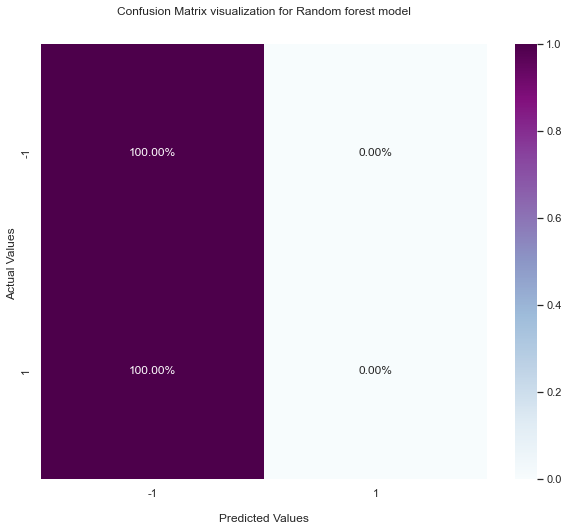

In [204]:
import seaborn as sns
import matplotlib.pyplot as plt

#Setting figure size
sns.set(rc={'figure.figsize':(10,8)})
#Creating heatmap to visually interpret the values better
ax = sns.heatmap(cfsn_matrix, annot=True, 
            fmt='.2%', cmap='BuPu')

ax.set_title('Confusion Matrix visualization for Random forest model\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

#Setting ticket labels
ax.xaxis.set_ticklabels([-1, 1])
ax.yaxis.set_ticklabels([-1, 1])

# Displaying the heatmap
plt.show()

## Hyper parameter tuning and modeling

## Logistic Regression balanced

In [23]:
# define models and parameter and applying weights to our classes by assigning 
#class_weight="balanced" to balances it out. 
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight="balanced")
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(penalty=penalty,C=c_values)
grid_search_lr = GridSearchCV(estimator=lr, param_grid=grid, n_jobs=-1, 
                           cv=5, scoring='f1_macro',error_score=0,return_train_score=True)
start = time.time()
#Fit the mode
grid_search_lr.fit(X_train, y_train)
end = time.time() - start
print(f"Took {end} seconds")

C:\Users\walid raad\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Took 8.918367385864258 seconds


C:\Users\walid raad\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
grid_search_lr.best_params_

{'C': 100, 'penalty': 'l2'}

In [25]:
grid_search_lr.best_score_

0.5587114469714185

In [26]:
best_model_index = grid_search_lr.cv_results_["rank_test_score"].tolist().index(1)
best_model_index

0

In [27]:
log_split_test_scores = []
for x in range(5):
    # extract f-score of the best model (index='best_model_index') from each of the 5 splits
    val = grid_search_lr.cv_results_[f"split{x}_test_score"][best_model_index]
    log_split_test_scores.append(val)

In [28]:
cv_results = pd.DataFrame(grid_search_lr.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
0,"{'C': 100, 'penalty': 'l2'}",0.601682,0.558711,7.141662
1,"{'C': 10, 'penalty': 'l2'}",0.601079,0.558139,7.143835
2,"{'C': 1.0, 'penalty': 'l2'}",0.597196,0.556132,6.876222
3,"{'C': 0.1, 'penalty': 'l2'}",0.584122,0.550192,5.808740
4,"{'C': 0.01, 'penalty': 'l2'}",0.561747,0.541870,3.538412


## Logistic Regression oversampling

In [31]:
from sklearn.linear_model import LogisticRegression
lr_os = LogisticRegression()
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(penalty=penalty,C=c_values)
grid_search_oslr = GridSearchCV(estimator=lr_os, param_grid=grid, n_jobs=-1, 
                           cv=5, scoring='f1_macro',error_score=0,return_train_score=True)
start = time.time()
#Fit the mode
grid_search_oslr.fit(Xtrain_oslr, ytrain_oslr)
end = time.time() - start
print(f"Took {end} seconds")

C:\Users\walid raad\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Took 22.404768228530884 seconds


C:\Users\walid raad\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [35]:
grid_search_oslr.best_params_

{'C': 100, 'penalty': 'l2'}

In [36]:
grid_search_oslr.best_score_

0.9228223697972675

In [37]:
cv_results = pd.DataFrame(grid_search_oslr.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
0,"{'C': 100, 'penalty': 'l2'}",0.928791,0.922822,0.642667
1,"{'C': 10, 'penalty': 'l2'}",0.928537,0.922559,0.643871
2,"{'C': 1.0, 'penalty': 'l2'}",0.926307,0.920287,0.649835
3,"{'C': 0.1, 'penalty': 'l2'}",0.920001,0.914866,0.558238
4,"{'C': 0.01, 'penalty': 'l2'}",0.896175,0.892366,0.425043


## Decision Tree Balanced

In [38]:
from sklearn.tree import DecisionTreeClassifier
# define models and parameter and applying weights to our classes by assigning class_weight="balanced"
dt = DecisionTreeClassifier(class_weight="balanced",random_state=7)
criterion = ['gini',"entropy"]
max_depth = [10,50,100]
max_features=["auto","sqrt",None]
# define grid search
grid = dict(criterion=criterion,max_depth=max_depth,max_features=max_features)
grid_search_dt = GridSearchCV(estimator=dt, param_grid=grid, n_jobs=-1, cv=5, scoring='f1_macro',
                              error_score=0,return_train_score=True)
start = time.time()
grid_search_dt.fit(X_train, y_train)
#Fit the model 

end = time.time() - start
print(f"Took {end} seconds")

Took 46.54943108558655 seconds


In [39]:
grid_search_dt.best_estimator_

DecisionTreeClassifier(class_weight='balanced', max_depth=50,
                       max_features='auto', random_state=7)

In [40]:
grid_search_dt.best_score_

0.6597411599672849

In [41]:
#extracting index number for the best achieved model
best_model_index = grid_search_dt.cv_results_["rank_test_score"].tolist().index(1)
best_model_index

3

In [42]:
dt_split_test_scores = []
for x in range(5):
    # extract f-score of the best model (index='best_model_index') from each of the 5 splits
    val = grid_search_dt.cv_results_[f"split{x}_test_score"][best_model_index]
    dt_split_test_scores.append(val)

In [43]:
cv_results = pd.DataFrame(grid_search_dt.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
3,"{'criterion': 'gini', 'max_depth': 50, 'max_features': 'auto'}",0.936067,0.659741,29.519893
4,"{'criterion': 'gini', 'max_depth': 50, 'max_features': 'sqrt'}",0.936067,0.659741,29.519893
6,"{'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto'}",0.940619,0.658320,30.012082
7,"{'criterion': 'gini', 'max_depth': 100, 'max_features': 'sqrt'}",0.940619,0.658320,30.012082
16,"{'criterion': 'entropy', 'max_depth': 100, 'max_features': 'sqrt'}",0.940619,0.656627,30.192044
15,"{'criterion': 'entropy', 'max_depth': 100, 'max_features': 'auto'}",0.940619,0.656627,30.192044
12,"{'criterion': 'entropy', 'max_depth': 50, 'max_features': 'auto'}",0.940619,0.656627,30.192044
13,"{'criterion': 'entropy', 'max_depth': 50, 'max_features': 'sqrt'}",0.940619,0.656627,30.192044
5,"{'criterion': 'gini', 'max_depth': 50, 'max_features': None}",0.918550,0.653477,28.857741
17,"{'criterion': 'entropy', 'max_depth': 100, 'max_features': None}",0.940619,0.653229,30.553232


## Decision Tree OverSampling

In [72]:
from sklearn.tree import DecisionTreeClassifier
dt_os = DecisionTreeClassifier(random_state=7)
criterion = ['gini',"entropy"]
max_depth = [10,50,100]
max_features=["auto","sqrt",None]
# define grid search
grid = dict(criterion=criterion,max_depth=max_depth,max_features=max_features)
grid_search_dtos = GridSearchCV(estimator=dt_os, param_grid=grid, n_jobs=-1, cv=5, scoring='f1',
                              error_score=0,return_train_score=True)
start = time.time()
grid_search_dtos.fit(Xtrain_oslr, ytrain_oslr)
#Fit the model 

end = time.time() - start
print(f"Took {end} seconds")

Took 45.93230891227722 seconds


In [73]:
grid_search_dtos.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=50, max_features='auto',
                       random_state=7)

In [74]:
grid_search_dtos.best_score_

0.9937278832440128

In [75]:
cv_results = pd.DataFrame(grid_search_dtos.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
16,"{'criterion': 'entropy', 'max_depth': 100, 'max_features': 'sqrt'}",0.997969,0.993728,0.424979
15,"{'criterion': 'entropy', 'max_depth': 100, 'max_features': 'auto'}",0.997969,0.993728,0.424979
12,"{'criterion': 'entropy', 'max_depth': 50, 'max_features': 'auto'}",0.997946,0.993728,0.422682
13,"{'criterion': 'entropy', 'max_depth': 50, 'max_features': 'sqrt'}",0.997946,0.993728,0.422682
6,"{'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto'}",0.997969,0.993662,0.431570
7,"{'criterion': 'gini', 'max_depth': 100, 'max_features': 'sqrt'}",0.997969,0.993662,0.431570
3,"{'criterion': 'gini', 'max_depth': 50, 'max_features': 'auto'}",0.997893,0.993650,0.425252
4,"{'criterion': 'gini', 'max_depth': 50, 'max_features': 'sqrt'}",0.997893,0.993650,0.425252
8,"{'criterion': 'gini', 'max_depth': 100, 'max_features': None}",0.997486,0.992635,0.486350
17,"{'criterion': 'entropy', 'max_depth': 100, 'max_features': None}",0.997969,0.992572,0.540761


## XGBOOST Classifier

In [ ]:
from xgboost import XGBClassifier
# define models and parameter
xgb = XGBClassifier(random_state=7)
loss = ['deviance',"exponential"]
n_estimators = [200,300]
max_depth=[15,20]
# define grid search
grid = dict(loss=loss,n_estimators=n_estimators,max_depth=max_depth)
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=grid, n_jobs=-1, cv=5, scoring='f1',
                              error_score=0,return_train_score=True)
start = time.time()
grid_search_xgb.fit(X_train, y_train)
#Fit the model 

end = time.time() - start
print(f"Took {end} seconds")

In [ ]:
grid_search_xgb.best_estimator_

In [ ]:
grid_search_xgb.best_score_

In [ ]:
best_model_index = grid_search_xgb.cv_results_["rank_test_score"].tolist().index(1)
best_model_index

In [ ]:
dt_split_test_scores = []
for x in range(5):
    # extract f-score of the best model (index='best_model_index') from each of the 5 splits
    val = grid_search_xgb.cv_results_[f"split{x}_test_score"][best_model_index]
    dt_split_test_scores.append(val)

In [ ]:
cv_results = pd.DataFrame(grid_search_xgb.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)